In [1]:
import project_path
import os
import numpy as np
import json
from tqdm import tqdm
from typing import List, Dict, Any, Union, Tuple
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd

from attwizard.decoder import get_attention_representation
from attwizard.aligner import map_to_char_level
from attwizard.aligner import tokenize_char_level

from codeattention.source_code import SourceCode

from scipy.stats import spearmanr
from scipy.stats import kstest
from scipy.spatial.distance import jensenshannon

from attwizard.script.utils import read_data_in_parallel
from attwizard.script.utils import load_json_file

# EDA
from attwizard.visualizer.eda import visualize_corr_vs
from attwizard.visualizer.eda import visualize_code_heatmap_codegen
from attwizard.visualizer.eda import plot_histogram_in_parallel

# Goal
Here we study how distant are the prediction of the next token of the followup and of the gaussian. 
But first we consider the ground tuth.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
COMPARISON_FOLDER_CODEGEN = "cmp_v05"
COMPARISON_FOLDER_GPTJ = "cmp_v05_gptj"
OUT_PAPER_FOLDER = "../data/paper_figures"

In [68]:
# How far are the top 3 next positions in our ground truth?

In [69]:
#ground_truth_folder = "../data/eye_tracking_attention/eye_v10/decay_0.1/data_followup_tokens_tokens_model/"
ground_truth_folder = "../data/eye_tracking_attention/eye_v10/decay_0.1_Salesforce_codegen-16B-multi/data_followup_tokens_tokens_model"
#ground_truth_folder = "../data/eye_tracking_attention/eye_v10/decay_0.1_EleutherAI_gpt-j-6B/data_followup_tokens_tokens_model"
ground_truth_matrices = read_data_in_parallel(
    base_folder=ground_truth_folder, 
    file_type_extension=".npy",
    read_function=np.load,)


n of data read:  92


In [ ]:

# read metadata
all_tokenization_codegen = read_data_in_parallel(
    base_folder='../data/eye_tracking_attention/eye_v10/att_weights_Salesforce_codegen-16B-multi/metadata',
    #base_folder='../data/eye_tracking_attention/eye_v10/decay_0.1_EleutherAI_gpt-j-6B/data_followup_tokens_tokens_model/metadata',
    file_type_extension='.json',
    read_function=load_json_file,
)
# read metadata
all_human_metadata = read_data_in_parallel(
    base_folder='../data/eye_tracking_attention/eye_v10/metadata',
    file_type_extension='.json',
    read_function=load_json_file,
)

In [14]:
# read data
gauss_matrices = read_data_in_parallel(
    base_folder='../data/model_output/exp_v10/codegen/att_gaussian_neighbors_10',
    file_type_extension='.npy',
    read_function=np.load,
)

n of data read:  135


In [15]:
# followup matrices 
followup_matrices = read_data_in_parallel(
    base_folder='../data/model_output/exp_v10/codegen/followup_first_layer',
    file_type_extension='.npy',
    read_function=np.load,
)

n of data read:  135


In [16]:
all_human_metadata['0480e5'].keys()

dict_keys(['user_name', 'task_number', 'source_code', 'tokenization', 'raw_text'])

In [70]:
# check that the have the same length
for k, matrix in ground_truth_matrices.items():
    # get corresponding filename
    filename = all_human_metadata[k]['source_code'].split('/')[1] + "_0_Salesforce_codegen-16B-multi"
    print(filename)
    # get corresponding matrix from the machine
    machine_matrix = followup_matrices[filename]
    # machine_matrix = gauss_matrices[filename]
    print(f"Human: {matrix.shape}, Machine: {machine_matrix.shape}")
    # get size of the followup matrix
    size_followup = matrix.shape[1]
    # check tha it is square
    assert size_followup == matrix.shape[0]
    # get the length of the tokenization
    c_tokenization = all_tokenization_codegen[k]#['model_tokens']
    len_tokenization = len(c_tokenization)
    # check that the size of the followup matrix is the same 
    # as the length of the tokenization
    print(f"{k}: followup: {size_followup} == tokens: {len_tokenization}")
    assert size_followup == len_tokenization

tree_Q2.py_0_Salesforce_codegen-16B-multi
Human: (507, 507), Machine: (526, 526)
0480e5: followup: 507 == tokens: 507
triangle_Q3.py_0_Salesforce_codegen-16B-multi
Human: (518, 518), Machine: (617, 617)
08147e: followup: 518 == tokens: 518
triangle_Q3.cpp_0_Salesforce_codegen-16B-multi
Human: (692, 692), Machine: (789, 789)
09601c: followup: 692 == tokens: 692
hannoi_Q2.py_0_Salesforce_codegen-16B-multi
Human: (216, 216), Machine: (315, 315)
0d7601: followup: 216 == tokens: 216
multithread_Q2.py_0_Salesforce_codegen-16B-multi
Human: (756, 756), Machine: (786, 786)
1181b7: followup: 756 == tokens: 756
hannoi_Q1.cs_0_Salesforce_codegen-16B-multi
Human: (292, 292), Machine: (323, 323)
155d45: followup: 292 == tokens: 292
multithread_Q1.py_0_Salesforce_codegen-16B-multi
Human: (768, 768), Machine: (866, 866)
161f21: followup: 768 == tokens: 768
hannoi_Q2.cpp_0_Salesforce_codegen-16B-multi
Human: (283, 283), Machine: (380, 380)
1d5b6a: followup: 283 == tokens: 283
triangle_Q3.py_0_Salesforc

In [45]:
# average distance between current token and next token?

In [22]:
all_records = []
for k, matrix in list(ground_truth_matrices.items())[:]:
    #print(k)
    #print(matrix)
    # for each line in the matrix
    for i in range(matrix.shape[0]):
        line = matrix[i]
        # get the position of the maximum value
        max_pos = np.argmax(line)
        distance_from_max = max_pos - i
        all_records.append({
            'unique_data_id': k,
            'current_token_position': i,
            'target_position': max_pos,
            'att_value_in_target': line[max_pos],
            'total_tokens': len(line),
            'distance_current_to_target': distance_from_max,
        })
df_distance_in_tokens = pd.DataFrame.from_records(all_records)
df_distance_in_tokens.head(140)

,unique_data_id,current_token_position,target_position,att_value_in_target,total_tokens,distance_current_to_target
0,0480e5,0,0,0.000000,507,0
1,0480e5,1,0,0.000000,507,-1
2,0480e5,2,0,0.000000,507,-2
3,0480e5,3,0,0.000000,507,-3
4,0480e5,4,0,0.000000,507,-4
...,...,...,...,...,...,...
135,0480e5,135,149,10.098278,507,14
136,0480e5,136,149,5.073014,507,13
137,0480e5,137,0,0.000000,507,-137
138,0480e5,138,132,2.507711,507,-6


<AxesSubplot:xlabel='distance_current_to_target', ylabel='att_value_in_target'>

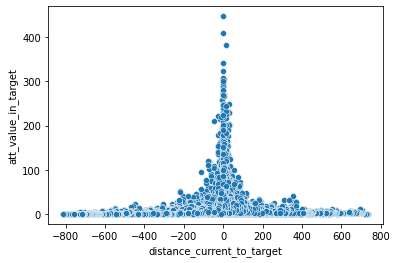

In [23]:
sns.scatterplot(
    data=df_distance_in_tokens,
    y='att_value_in_target',
    x='distance_current_to_target',
)
# normalize this to sum up tp 1 before subtracting it from the followup/better to divide it.

<AxesSubplot:xlabel='distance_curent_to_target', ylabel='att_value_in_target'>

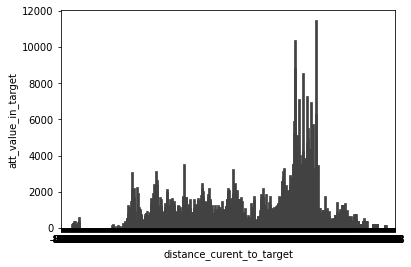

In [81]:
sns.barplot(
    data=df_distance_in_tokens,
    y='att_value_in_target',
    x='distance_current_to_target',
)

<AxesSubplot:xlabel='distance_current_to_target', ylabel='mean_att_value_in_target'>

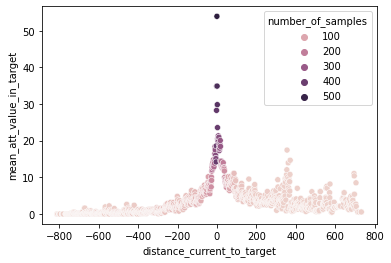

In [42]:
df_grouped = df_distance_in_tokens.groupby('distance_current_to_target').agg({
    'att_value_in_target': ['mean', 'count'],})
df_grouped.columns = ['mean_att_value_in_target', 'number_of_samples']
df_grouped = df_grouped.reset_index()
df_grouped.head()
# plot
sns.scatterplot(
    data=df_grouped,
    x='distance_current_to_target',
    y='mean_att_value_in_target',
    hue='number_of_samples',
)   

In [89]:
len(df_grouped)

1422

In [98]:
len(df_grouped['distance_current_to_target'].unique())

1422

In [99]:
df_grouped['distance_current_to_target'].min() - df_grouped['distance_current_to_target'].max()

-1545

In [100]:
df_grouped.head()

,distance_current_to_target,mean_att_value_in_target,number_of_samples
0,-812,0.0,1
1,-811,0.0,1
2,-810,0.0,1
3,-809,0.0,1
4,-808,0.0,1


In [101]:
df_base = df_grouped
min_position = df_base["distance_current_to_target"].min()
max_position = df_base["distance_current_to_target"].max()
values_sum = df_base["mean_att_value_in_target"].sum()
positions = np.arange(min_position, max_position + 1)
values = np.array([
    df_base[df_base["distance_current_to_target"] == p]["mean_att_value_in_target"].values[0] / values_sum
    if p in df_base["distance_current_to_target"].unique() else 0
    for p in positions
]) 
assert len(positions) == len(values)

Text(0.5, 0, 'Distance from top-1 reccomendation and current token')

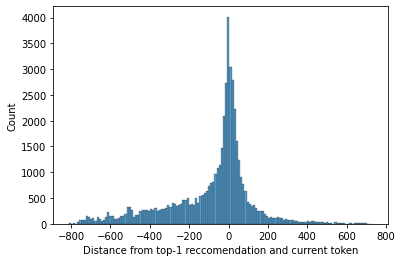

In [49]:
sns.histplot(
    data=df_distance_in_tokens,
    x='distance_from_target',
)
plt.xlabel("Distance from top-1 reccomendation and current token")

In [32]:
# how about the average distance in terms of line?

In [33]:
from attwizard.shaper import aggregate_dim_tokens_to_line

all_records_line = []
for k, matrix in list(ground_truth_matrices.items())[:1]:
    tokenization = all_tokenization_codegen[k]['tokenization']
    line_indices = np.array([t['l'] for t in tokenization])
    # aggregate the matrix by line
    matrix_by_line = aggregate_dim_tokens_to_line(
        matrix, 
        dim=1,
        line_indices=line_indices)
    total_lines = len(set(line_indices))
    size_new_matrix = matrix_by_line.shape[0]
    assert total_lines == size_new_matrix
    print(f"total_lines: {total_lines} == size_new_matrix: {size_new_matrix}")
    # for each line in the matrix
    for i in range(matrix_by_line.shape[0]):
        line = matrix_by_line[i]
        # get the position of the maximum value
        max_pos = np.argmax(line)
        distance_from_max = max_pos - i
        all_records.append({
            'file': k,
            'line': i,
            'max_pos': max_pos,
            'total_tokens': len(line),
            'distance_from_max': distance_from_max,
        })

AssertionError: The length of the line_indices must match the length of the target dimension of the att_tensor.Got 862 and 837

# Experiment with Removing Base

In [5]:
values = np.array([1, 2, 3])
pad_length = 5
res = np.pad(values, (pad_length, pad_length), "constant")
res 

array([0, 0, 0, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0])

In [6]:
df_base = pd.read_csv('../data/eye_tracking_attention/eye_v10/decay_0.1_Salesforce_codegen-16B-multi/data_avg_followup/df_base_att_based_on_distance.csv')

<AxesSubplot:xlabel='distance_current_to_target', ylabel='mean_att_value_in_target'>

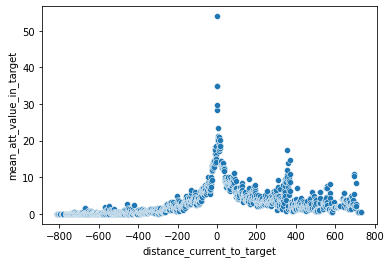

In [8]:
sns.scatterplot(
    data=df_base,
    x='distance_current_to_target',
    y='mean_att_value_in_target',
)

In [4]:
df_base = pd.read_csv('../data/eye_tracking_attention/eye_v10/decay_0.1_Salesforce_codegen-16B-multi/data_avg_followup/df_base_top1_prob_based_on_distance.csv')

<AxesSubplot:xlabel='distance_current_to_target', ylabel='mean_prob_to_go_to_top1_target'>

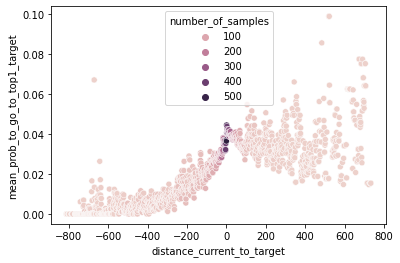

In [6]:
sns.scatterplot(
    data=df_base,
    x='distance_current_to_target',
    y='mean_prob_to_go_to_top1_target',
    hue='number_of_samples',
)

In [7]:
df_base[df_base['distance_current_to_target'] == 0].head()

,distance_current_to_target,mean_prob_to_go_to_top1_target,number_of_samples
784,0,0.036514,525


In [48]:
# compare matrices
FODLER_A = '../data/eye_tracking_attention/eye_v10/decay_0.1_Salesforce_codegen-16B-multi/data_followup_tokens_tokens_model/'
FOLDER_B = '../data/eye_tracking_attention/eye_v10/decay_0.1/data_followup_tokens_tokens_model/'
a = np.load("../data/eye_tracking_attention/eye_v10/decay_0.1_Salesforce_codegen-16B-multi/data_followup_tokens_tokens_model/0d7601.npy")
b = np.load("../data/eye_tracking_attention/eye_v10/decay_0.1/data_followup_tokens_tokens_model/0d7601.npy")
assert a.shape == b.shape

In [26]:
# check that the two matrices are identical
np.all(a == b)

True

In [49]:
all_a = read_data_in_parallel(
    FODLER_A,
    file_type_extension='.npy',
    read_function=np.load,
)
all_b = read_data_in_parallel(
    FOLDER_B,
    file_type_extension='.npy',
    read_function=np.load,
)

n of data read:  92
n of data read:  92


In [50]:
# iterate over all the keys and check that the matrices are identical
count = 0
for k in all_a.keys():
    # same shape
    assert all_a[k].shape == all_b[k].shape
    print(np.all(all_a[k] == all_b[k]))
    if not np.all(all_a[k] == all_b[k]):
        count += 1
        print(f"key: {k}")
print(f"count false: {count}")



True
True
True
False
key: 97a19f
True
True
True
True
True
True
False
key: 500208
True
True
False
key: cbdc06
True
True
True
True
True
True
True
True
True
True
False
key: f5e35b
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
key: b6cb6e
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
key: b595bc
True
False
key: 9e5778
True
True
True
True
True
False
key: e84aa9
True
False
key: 4a262b
True
True
True
False
key: 44d4f6
True
True
True
True
True
True
True
True
False
key: 2babb5
True
True
True
True
True
False
key: f4bbec
count false: 12


# Create baseline depending on all positions

In [12]:
df_followup = pd.read_csv('../data/eye_tracking_attention/eye_v10/decay_0.1_Salesforce_codegen-16B-multi/data_avg_followup/df_entire_followup.csv')
df_followup.head()

/tmp/ipykernel_3341239/998211907.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_followup = pd.read_csv('../data/eye_tracking_attention/eye_v10/decay_0.1_Salesforce_codegen-16B-multi/data_avg_followup/df_entire_followup.csv')


,unique_data_id,current_token_position,target_position,total_tokens,distance_current_to_target,prob_to_go_to_target,followup_abs_value,total_followup_abs_value
0,f4bbec,0,0,292,0,0.0,0.0,30.21977
1,f4bbec,0,1,292,-1,0.0,0.0,30.21977
2,f4bbec,0,2,292,-2,0.0,0.0,30.21977
3,f4bbec,0,3,292,-3,0.0,0.0,30.21977
4,f4bbec,0,4,292,-4,0.0,0.0,30.21977


In [37]:
# group by distance current to target and ge the average probability
df_grouped = df_followup.groupby('distance_current_to_target').agg({
    "prob_to_go_to_target": ["mean", "count"]})
# collapse the multiindex 
# FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
df_grouped.columns = df_grouped.columns.to_flat_index()
# normalize column names
df_grouped.columns = ['_'.join(col).strip() for col in df_grouped.columns.values]
df_grouped = df_grouped.reset_index()
# invert the distance
df_grouped['distance_current_to_target'] = df_grouped['distance_current_to_target'] * -1

In [38]:
df_grouped.head()

,distance_current_to_target,prob_to_go_to_target_mean,prob_to_go_to_target_count
0,812,0.0,1
1,811,0.0,2
2,810,0.0,3
3,809,0.0,4
4,808,0.0,5


<AxesSubplot:xlabel='distance_current_to_target', ylabel='prob_to_go_to_target_mean'>

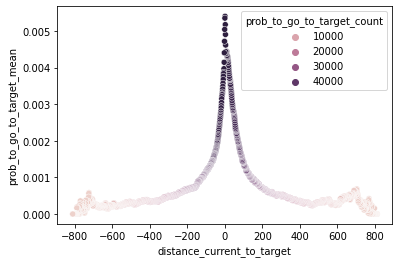

In [39]:
sns.scatterplot(
    data=df_grouped,
    x='distance_current_to_target',
    y='prob_to_go_to_target_mean',
    hue='prob_to_go_to_target_count'
)

In [40]:
# save to file
df_grouped.to_csv(
    '../data/eye_tracking_attention/eye_v10/decay_0.1_Salesforce_codegen-16B-multi/data_avg_followup/df_base_all_prob_based_on_distance.csv',
    index=False)

# Compute followup distance (machine)

In [4]:
# followup matrices 
machine_followup_matrices = read_data_in_parallel(
    base_folder='../data/model_output/exp_v10/codegen/followup',
    file_type_extension='.npy',
    read_function=np.load,
)

# import scipy coo matrix
from scipy.sparse import coo_matrix

all_coordinates = []
# iterate over all the keys and conver the matrices to coordinates format
for k in tqdm(machine_followup_matrices.keys()):
    m = machine_followup_matrices[k]
    # normalize matrices by line, dividing by the sum
    # if the sum is 0, then convert to 1 to avoid division by 0
    sum_of_each_row = np.sum(m, axis=1)
    sum_of_each_row[sum_of_each_row == 0] = 1
    norm_m = m / sum_of_each_row[:, None]
    # assert that each row must sum to 1
    assert np.all([np.isclose(np.sum(norm_m[i, :]), 1) for i in range(m.shape[0])])
    # convert to coordinate matrix
    norm_m = coo_matrix(norm_m)
    #print(f"key: {k} - shape: {m.shape}")
    # unique_data_id	current_token_position	target_position	total_tokens	
    # distance_current_to_target	prob_to_go_to_target	followup_abs_value	total_followup_abs_value
    new_coordinates = [
        {
            'unique_data_id': k,
            'current_token_position': row,
            'target_position': col,
            'total_tokens': norm_m.shape[0],
            'prob_to_go_to_target': value,
            'distance_current_to_target': col - row,
            'followup_abs_value': m[row][col],
            'total_followup_abs_value': np.sum(m[row, :]),
        } for row, col, value in zip(norm_m.row, norm_m.col, norm_m.data)
    ]
    all_coordinates.extend(new_coordinates)
df_all_followup = pd.DataFrame.from_records(all_coordinates)
df_all_followup.head()

n of data read:  135


100%|██████████| 135/135 [05:25<00:00,  2.41s/it]


,unique_data_id,current_token_position,target_position,total_tokens,prob_to_go_to_target,distance_current_to_target,followup_abs_value,total_followup_abs_value
0,Nqueens_Q1.cpp_0_Salesforce_codegen-16B-multi,0,0,625,0.004542,0,32.397919,7132.937012
1,Nqueens_Q1.cpp_0_Salesforce_codegen-16B-multi,0,1,625,0.002073,1,14.788752,7132.937012
2,Nqueens_Q1.cpp_0_Salesforce_codegen-16B-multi,0,2,625,0.001885,2,13.445631,7132.937012
3,Nqueens_Q1.cpp_0_Salesforce_codegen-16B-multi,0,3,625,0.001946,3,13.883986,7132.937012
4,Nqueens_Q1.cpp_0_Salesforce_codegen-16B-multi,0,4,625,0.002354,4,16.794365,7132.937012


In [5]:
df_all_followup.to_csv(
    '../data/model_output/exp_v10/codegen/df_all_followup_codegen.csv',
    index=False
)

# Compute the same for different matrices

In [57]:
def see_base_distribution_of(machine_att_folder):
    """Plot the average machine attention distribution."""
    print(f"machine_att_folder: {machine_att_folder}")
    # read data
    matrices = read_data_in_parallel(
        base_folder=f'../data/model_output/exp_v10/codegen/{machine_att_folder}',
        file_type_extension='.npy',
        read_function=np.load,
    )

    # import scipy coo matrix
    from scipy.sparse import coo_matrix

    all_coordinates = []
    # iterate over all the keys and conver the matrices to coordinates format
    for k in tqdm(matrices.keys()):
        m = matrices[k]
        # normalize matrices by line, dividing by the sum
        # if the sum is 0, then convert to 1 to avoid division by 0
        sum_of_each_row = np.sum(m, axis=1)
        sum_of_each_row[sum_of_each_row == 0] = 1
        m = m / sum_of_each_row[:, None]
        # assert that each row must sum to 1
        assert np.all([np.isclose(np.sum(m[i, :]), 1) for i in range(m.shape[0])])
        # convert to coordinate matrix
        m = coo_matrix(m)
        #print(f"key: {k} - shape: {m.shape}")
        new_coordinates = [
            {
                'unique_data_id': k,
                'current_token_position': row,
                'target_position': col,
                'total_tokens': m.shape[0],
                'prob_to_go_to_target': value,
                'distance_current_to_target': col - row,
            } for row, col, value in zip(m.row, m.col, m.data)
        ]
        all_coordinates.extend(new_coordinates)
    df_gauss_all = pd.DataFrame.from_records(all_coordinates)
    df_gauss_all.head()

    # group by distance current to target and ge the average probability
    df_grouped = df_gauss_all.groupby('distance_current_to_target').agg({
        "prob_to_go_to_target": ["mean", "count"]})
    # collapse the multiindex 
    # FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
    df_grouped.columns = df_grouped.columns.to_flat_index()
    # normalize column names
    df_grouped.columns = ['_'.join(col).strip() for col in df_grouped.columns.values]
    df_grouped = df_grouped.reset_index()
    # invert the distance
    sns.scatterplot(
        data=df_grouped,
        x='distance_current_to_target',
        y='prob_to_go_to_target_mean',
        hue='prob_to_go_to_target_count'
    )
    plt.xlim(-1000, 1000)
    plt.title(machine_att_folder)
    plt.show()
    return df_grouped

machine_att_folder: att_gaussian_neighbors_30
n of data read:  135


100%|██████████| 135/135 [00:16<00:00,  7.96it/s]


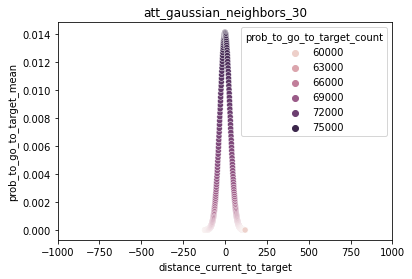

machine_att_folder: followup
n of data read:  135


100%|██████████| 135/135 [00:54<00:00,  2.48it/s]


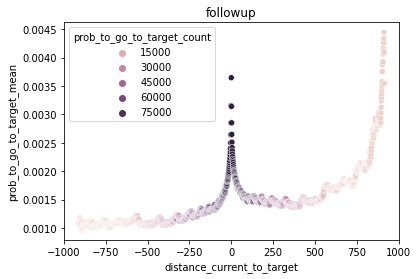

machine_att_folder: naive_max
n of data read:  135


100%|██████████| 135/135 [00:29<00:00,  4.63it/s]


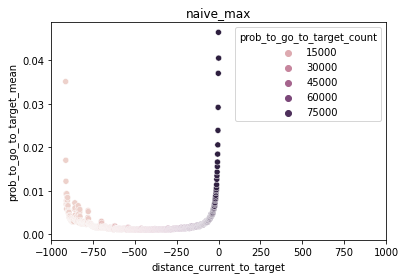

machine_att_folder: rollout_condensed_all
n of data read:  135


100%|██████████| 135/135 [00:28<00:00,  4.70it/s]


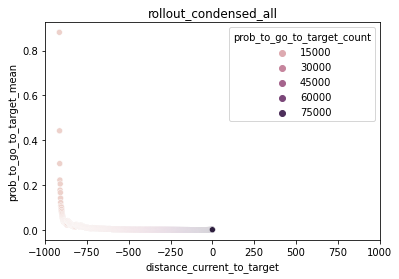

In [58]:
all_base_distrib = {}

folders_to_see = [
    'att_gaussian_neighbors_30',
    'followup',
    'naive_max',
    'rollout_condensed_all',
]

for folder in folders_to_see:
    all_base_distrib[folder] = see_base_distribution_of(machine_att_folder=folder)

In [59]:
np.ones(20)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [60]:
df_full_modeling = pd.read_csv('../data/eye_tracking_attention/eye_v10/decay_0.1_Salesforce_codegen-16B-multi/data_avg_followup/baseline_ground_truth.csv')

In [71]:
df_full_modeling[
    (df_full_modeling['total_tokens'] == 693)
].head()

,current_token_position,total_tokens,target_position,p_target
8551,0,693,0,0.007267
8552,1,693,0,0.000782
8553,2,693,0,0.000744
8554,3,693,0,0.000723
8555,4,693,0,0.000709


In [62]:
df_followup[
    (df_followup['total_tokens'] == 690)
].head()

,unique_data_id,current_token_position,target_position,total_tokens,distance_current_to_target,prob_to_go_to_target,followup_abs_value,total_followup_abs_value


In [64]:
followup_matrices = read_data_in_parallel(
        base_folder=f'../data/model_output/exp_v10/codegen/followup',
        file_type_extension='.npy',
        read_function=np.load,
    )

n of data read:  135


In [70]:
for k, m in ground_truth_matrices.items():
    print(f"key: {k} - shape: {m.shape}")
    if m.shape[0] == 690:
        break 

key: 0480e5 - shape: (507, 507)
key: 08147e - shape: (518, 518)
key: 09601c - shape: (692, 692)
key: 0d7601 - shape: (216, 216)
key: 1181b7 - shape: (756, 756)
key: 155d45 - shape: (292, 292)
key: 161f21 - shape: (768, 768)
key: 1d5b6a - shape: (283, 283)
key: 2babb5 - shape: (518, 518)
key: 300bd1 - shape: (292, 292)
key: 38606b - shape: (611, 611)
key: 3b0e57 - shape: (693, 693)
key: 3b39e2 - shape: (722, 722)
key: 3d9b54 - shape: (216, 216)
key: 3e474f - shape: (450, 450)
key: 4022a9 - shape: (283, 283)
key: 403482 - shape: (599, 599)
key: 43e18c - shape: (611, 611)
key: 448383 - shape: (611, 611)
key: 44d4f6 - shape: (292, 292)
key: 44e060 - shape: (519, 519)
key: 4a262b - shape: (756, 756)
key: 4a5896 - shape: (622, 622)
key: 4c260d - shape: (756, 756)
key: 500208 - shape: (518, 518)
key: 5403f5 - shape: (226, 226)
key: 545804 - shape: (721, 721)
key: 548472 - shape: (283, 283)
key: 56f44e - shape: (635, 635)
key: 5a70af - shape: (507, 507)
key: 5bf279 - shape: (725, 725)
key: 639